# Sesión 4.2. Teoría - Redes Neuronales Recurrentes Avanzadas

Profesor: [Jorge Calvo Zaragoza](mailto:jcalvo@dlsi.ua.es)

## Resumen
En esta sesión:
  * Introducimos el modelo secuencia a secuencia (sequence-to-sequence, o *seq2seq*)    
  * Comentaremos problemas complejos que utilizan estas estructuras.

## Introducción

Dependiendo de la tipología de las entradas y las salidas, podemos formular diferentes escenarios de aprendizaje automático:

.

![Esquemas con RNN](http://www.dlsi.ua.es/~jgallego/deepraltamira/rnn_diagrams.png)

.

* Algunos ejemplos de estos tipos de arquitecturas serían:

 * **Uno a uno:** clasificación o regresión convencional en el cual a una entrada le corresponde una salida.
 * **Muchos a uno:** clasificación de secuencias, en las cuales queremos asignar una categoria a una secuencia.
 * **Uno a muchos:** tareas en las cuáles se quiere obtener una secuencia a partir de una única entrada. Ejemplo: descripción automática de imagen.
 * **Muchos a muchos (desacopladas o no):** tareas en las cuales tanto la entrada como la salida son secuencias. Se puede plantear de diferente forma dependiendo de si las secuencias son desacopladas (traducción automática) o si hay una fuerte relación entre cada elemento de la entrada y la salida (etiquetado gramatical).

La flexibilidad para construir las distintas topologías mostradas en la figura anterior se proporcionan a través de siguientes parámetros:

* **return_sequences**: cuando está desactivado, sólo devuelve la salida del último instante de tiempo (many to one); cuando está activado, devuelve la salida de todos los instantes (many to many).
* **return_state**: indica si se devuelven los estados recurrentes de las neuronas.



In [ ]:
%%capture --no-stdout
import tensorflow as tf

# La entrada a una red recurrente tiene dos dimensiones:
# - El número de instantes de tiempo (None para indicar que variable)
# - Número de características de entrada
T = 100
caracteristicas = 2
capa_entrada = tf.keras.layers.Input(shape=(T, caracteristicas))

# LSTM
x0 = tf.keras.layers.LSTM(64)(capa_entrada)
x1 = tf.keras.layers.LSTM(64,return_state=True)(capa_entrada)
print('LSTM: ' + str(x0))
print('LSTM + return_state: ' + str(x1))
print()

LSTM: Tensor("lstm_12/Identity:0", shape=(None, 64), dtype=float32)
LSTM + return_state: [<tf.Tensor 'lstm_13/Identity:0' shape=(None, 64) dtype=float32>, <tf.Tensor 'lstm_13/Identity_1:0' shape=(None, 64) dtype=float32>, <tf.Tensor 'lstm_13/Identity_2:0' shape=(None, 64) dtype=float32>]



## Arquitectura secuencia a secuencia

De entre todos los enfoques mostrados al principio de la sesión, el más flexible es el de secuencia a secuencia desacoplado (*sequence to sequence*, o *seq2seq*). Típicamente, se implementa con una arquitectura encoder-decoder:

![texto alternativo](https://docs.google.com/uc?id=1poBXbaLFiEN0IPZtR0IIbySEnSLGRvih)

Esta arquitectura cuenta con dos redes neuronales independientes:
* El **encoder** es una red recurrente que se encarga de procesar la entrada elemento a elemento, almacenando en su estado interno una codificación compacta y representativa de la información procesada hasta el momento. Al estado interno de las neuronas del encoder se le llama *context vector* o *thought vector*.
* El **decoder** es otra red recurrente que recibe el *context vector* de la última etapa del encoder. En cada paso, predice un elemento del dominio de salida, utilizando el estado interno de la red recurrente y el último elemento predicho. El proceso acaba cuando se emite el elemento especial *EOS* (end of sentence).

![texto alternativo](https://devblogs.nvidia.com/wp-content/uploads/2015/06/Figure6_summary_vector_space.png)

Esta arquitectura se entrena de manera conjunta, para lo cual tan sólo hacen falta pares de secuencias de entrada y salida, sin necesidad de proporcionar ningun tipo de información acerca de la relación entre los elementos de las mismas.


## Ejemplo simple de encoder-decoder en Keras (con Embedding)


En este ejemplo vamos a realizar un ejercicio sin propósito: dada una secuencia de entrada, queremos replicarla en la salida de forma desacoplada. Es decir, primero utilizaremos un encoder para procesar toda la entrada, seguido de un decoder que debe replicar la secuencia a partir del *context vector*.

In [ ]:
"""
Vamos a crear el alfabeto del problema
"""

# De palabra a numero
word_to_int = {}
word_to_int["<PAD>"] = 0
word_to_int["<SOS>"] = 1
word_to_int["<EOS>"] = 2
word_to_int["0"] = 3
word_to_int["1"] = 4

# De numero a palabra
int_to_word = dict([(value, key) for (key, value) in word_to_int.items()])

tam_alfabeto = len(word_to_int)

print('Alfabeto de tamaño {}'.format( tam_alfabeto ))


Alfabeto de tamaño 5


Vamos a crear ahora el modelo.

In [ ]:
%%capture --no-stdout
import tensorflow as tf

# Para este enfoque, merece la pena definir los hiper-parámetros en variables
# Especialmente cuando hay que tener el mismo valor en sitios distintos
neuronas_rnn = 8
dim_embedding = 2

# Encoder
# - Consta de un Embedding y un LSTM
# - Crea un context vector a partir de los últimos estados internos del LSTM

entrada_encoder = tf.keras.layers.Input(shape=(None,))

embedding_encoder = tf.keras.layers.Embedding(input_dim=tam_alfabeto,
                              output_dim=dim_embedding)(entrada_encoder) # Capa embedding

salida_encoder, encoder_h, encoder_c = tf.keras.layers.LSTM(neuronas_rnn,
                                             return_state=True)(embedding_encoder) # Devolvemos los estados

context_vector = [encoder_h, encoder_c] # Creamos el `context vector`

# OJO: El `encoder_outputs` no se usa

# Decoder
# - Consta de una entrada con Embedding
# - El LSTM procesa la entrada del decoder pero su estado inicial es el del context vector
# - La salida es una predicción de cada posible categoria

entrada_decoder = tf.keras.layers.Input(shape=(None,))

embedding_decoder = tf.keras.layers.Embedding(input_dim=tam_alfabeto,
                              output_dim=dim_embedding)(entrada_decoder)

salida_decoder, _, _ = tf.keras.layers.LSTM(neuronas_rnn,
                             return_sequences=True,
                             return_state=True)(embedding_decoder,
                                                initial_state=context_vector) # El `context vector` es el estado inicial del encoder

# OJO: El último estado del decoder no se usa

# Clasificación
# - El decoder es finalmente conectado a una capa para clasificar
# - Tantas neuronas como palabras y activación softmax

clasificacion = tf.keras.layers.Dense(tam_alfabeto, activation='softmax')(salida_decoder)

# Creamos el modelo:
# - Dos entradas (entrada del encoder y entrada del decoder)

model_embed = tf.keras.models.Model([entrada_encoder, entrada_decoder], clasificacion)

model_embed.compile(optimizer='rmsprop',
                    loss='categorical_crossentropy')

model_embed.summary()




Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 2)      10          input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 2)      10          input_3[0][0]                    
______________________________________________________________________________________________

Vamos a definir ahora la función generadora teniendo en cuenta que los lotes estarán compuestos por tres componentes:
* **Entrada del encoder (X)**: palabras proporcionadas como entrada del problema
* **Entrada del decoder (T)**: comenzando por *SOS* y después la predicción en el instante anterior
* **Salida del decoder (Y)**: secuencia de salida esperada

In [ ]:
import random
import numpy as np

# Cada lote estará compuesto por tres vectores de tamaño `tam_lote`
def generador_embed(tam_lote):
  while True:
    X = [] # Encoder input
    T = [] # Decoder input
    Y = [] # Decoder output

    # Generamos secuencia de 0's y 1's aleatorias
    for _ in range(tam_lote):
      x = [random.choice(['0','1']) for _ in range(random.randint(1,5)) ]
      t = ['<SOS>'] + x   # La entrada del decoder empieza por SOS
      y = x + ['<EOS>']   # La última predicción del decoder es EOS

      X.append(x)
      T.append(t)
      Y.append(y)

    # Prepare data
    longitud_maxima = max([len(n) for n in X])

    X_lote = np.zeros((tam_lote, longitud_maxima),
                         dtype=np.int32)
    T_lote = np.zeros((tam_lote, longitud_maxima+1), # ¿ +1 ?
                         dtype=np.int32)
    Y_lote = np.zeros((tam_lote, longitud_maxima+1, tam_alfabeto), # ¿por qué la última dimension?
                          dtype=np.int32)

    for idx_x, x in enumerate(X):
      for idx_p, palabra in enumerate(x):
          X_lote[idx_x][idx_p] = word_to_int[palabra]

    for idx_t, t in enumerate(T):
      for idx_p, palabra in enumerate(t):
          T_lote[idx_t][idx_p] = word_to_int[palabra]

    for idx_y, y in enumerate(Y):
      for idx_p, palabra in enumerate(y):
          Y_lote[idx_y][idx_p][word_to_int[palabra]] = 1.


    yield [X_lote, T_lote], Y_lote

Podemos inspeccionar una salida típica de la función generadora

In [ ]:
g = generador_embed(16)

[x_i, t_i], y_i = next(g)

print('X:', x_i.shape)
print('T:', t_i.shape)
print('Y:', y_i.shape)

X: (16, 5)
T: (16, 6)
Y: (16, 6, 5)


Con el modelo de red definido y con una función generadora podemos entrenar la red:

In [ ]:
%%capture --no-stdout

TAM_LOTE = 16
generadora_training = generador_embed(TAM_LOTE)

# Entrenamiento
print('Entrenamos la red...')
history = model_embed.fit_generator(generadora_training,
                                    steps_per_epoch=200,
                                    epochs=30,
                                    verbose=2)

Entrenamos la red...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
200/200 - 1s - loss: 0.8470
Epoch 2/30
200/200 - 1s - loss: 0.6709
Epoch 3/30
200/200 - 1s - loss: 0.5896
Epoch 4/30
200/200 - 1s - loss: 0.4956
Epoch 5/30
200/200 - 1s - loss: 0.4534
Epoch 6/30
200/200 - 1s - loss: 0.4233
Epoch 7/30
200/200 - 1s - loss: 0.3994
Epoch 8/30
200/200 - 1s - loss: 0.3886
Epoch 9/30
200/200 - 1s - loss: 0.3728
Epoch 10/30
200/200 - 1s - loss: 0.3633
Epoch 11/30
200/200 - 1s - loss: 0.3194
Epoch 12/30
200/200 - 1s - loss: 0.2803
Epoch 13/30
200/200 - 1s - loss: 0.2377
Epoch 14/30
200/200 - 1s - loss: 0.1844
Epoch 15/30
200/200 - 1s - loss: 0.1504
Epoch 16/30
200/200 - 1s - loss: 0.1234
Epoch 17/30
200/200 - 1s - loss: 0.1036
Epoch 18/30
200/200 - 1s - loss: 0.0889
Epoch 19/30
200/200 - 1s - loss: 0.0758
Epoch 20/30
200/200 - 1s - loss: 0.0662
Epoch 21/30
200/200 - 1s - loss: 0.0593
Epoch 22/30
200/200 - 1s - loss: 0.0552
Epoch 23/30
200/200 - 1s - loss:

Vamos a realizar también el código necesario para realizar una predicción sobre una secuencia de entrada:

In [ ]:
# -----------------------------------------------------------------
# La función `prediccion` recibe una secuencia y construye
# tanto la entrada del encoder como la entrada del decoder

def prediccion(secuencia):
  x = np.zeros((1, len(secuencia)), dtype=np.int32)
  t = np.zeros((1, len(secuencia)+1), dtype=np.int32)

  t[0][0] = word_to_int['<SOS>']
  for idx_p, palabra in enumerate(secuencia):
    x[0][idx_p]   = word_to_int[palabra]
    t[0][idx_p+1] = word_to_int[palabra] # ¿ +1 ?

  prediccion = model_embed.predict([x,t], verbose=0)[0]
  secuencia_predicha = [int_to_word[word] for word in np.argmax(prediccion,axis=1)]

  print('Secuencia de entrada:',secuencia,'\t','Secuencia de salida:', secuencia_predicha)



# Vamos a evaluar la siguiente secuencias
prediccion(['0'])
prediccion(['1'])
prediccion(['0','0'])
prediccion(['0','1'])
prediccion(['1','0'])
prediccion(['1','1'])

Secuencia de entrada: ['0'] 	 Secuencia de salida: ['1', '1']
Secuencia de entrada: ['1'] 	 Secuencia de salida: ['1', '0']
Secuencia de entrada: ['0', '0'] 	 Secuencia de salida: ['0', '1', '<EOS>']
Secuencia de entrada: ['0', '1'] 	 Secuencia de salida: ['0', '1', '<EOS>']
Secuencia de entrada: ['1', '0'] 	 Secuencia de salida: ['1', '0', '<EOS>']
Secuencia de entrada: ['1', '1'] 	 Secuencia de salida: ['1', '0', '0']


Como hemos utilizado una capa de *Embedding* podemos inspeccionar dónde se han situado los elementos del vocabulario en el espacio latente de dos dimensiones.

Representación de: ['<PAD>', '<SOS>', '<EOS>', '0', '1']
[[[ 0.01709491 -0.0917111 ]
  [ 0.02717096 -0.02154033]
  [ 0.02824816  0.01003578]
  [ 0.3412773   0.9308337 ]
  [ 0.94898736  0.07174742]]]


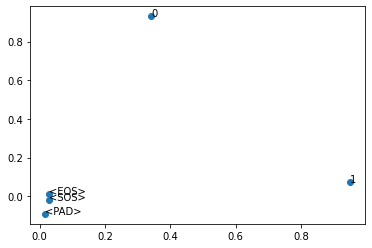

In [ ]:

# Creamos el modelo de embedding
model_matriz_embedding = tf.keras.models.Model(entrada_encoder,embedding_encoder)

# Comprobamos el embedding sobre este modelo
codificacion_numerica = [0,1,2,3,4]
vectores_embedding = model_matriz_embedding.predict(np.asarray([codificacion_numerica]))

print('Representación de: ' + str([int_to_word[idx] for idx in codificacion_numerica]))
print(vectores_embedding)

# Pintamos la representación vectorial con matplotlib
import numpy as np
from matplotlib import pyplot as plt

# Obtenemos las dos dimensiones por separado
x,y = vectores_embedding[0].T
plt.scatter(x,y)

# Las pintamos junto a su etiqueta
for idx, _ in enumerate(x):
  plt.annotate(int_to_word[idx],
               (x[idx], y[idx]))

plt.show()




## Ejemplos de tareas (I)

Una ventaja de esta arquitectura es que sirve para multitud de tareas que en el pasado se desarrollaban de forma independiente. Aunque cada tarea tiene sus particularidades, esta formulación similar permite que avances significativos en un campo sean generalizables a otro (como veremos más adelante con los modelos de atención).

La única restricción para llevar a cabo la mayoría de estas tareas son de índole logístico: ¿tenemos suficientes datos para aprender dicha tarea? ¿tenemos suficiente capacidad computacional para llevar a cabo el entrenamiento?


### Modelos de conversación

.

![texto alternativo](https://cdn-images-1.medium.com/max/1585/1*sO-SP58T4brE9EHazHSeGA.png)

.

### Traducción automática

.

![texto alternativo](https://www.wncc-iitb.org/images/semantics.png)

.

### Resumen de texto

.

![texto alternativo](https://cdn-images-1.medium.com/max/1600/1*Cu49wPEpWJPoI0a5AV9Q1Q.png)

.



### Ejemplos de tareas (II)

Se puede mantener este enfoque añadiendo una red convolucional que se encargue de aprender las características adecuadas para la tarea en cuestión. La fase de encoding puede ser o bien una simple red convolucional o una combinación de convolucional y recurrente. El segundo caso es especialmente util cuando la entrada, aun proveniendo de un domino gráfico, tiene también una componente secuencial.

Básicamente, estas arquitecturas se emplean en tareas cuya formulación es similar a la que se podría resolver mediante un enfoque encoder-decoder convencional pero en las cuales algún tipo de elemento de entrada es una imagen.

#### Descripción visual automática

.

![texto alternativo](https://docs.google.com/uc?id=1Q1KbFzrfS7qXIdR3zN7SkcabUwtVm2Rj)

.

#### *Visual Question Answering*  categórica

.

![texto alternativo](https://drive.google.com/uc?id=1hzWsAFmdKSku105HqYuExSsvqfMGj5ie)

.



# Contenido adicional de la sesión

## Modelos de atención

A menudo, la etapa de codificación es muy compleja. Es por ello que el context vector es insuficiente para capturar la información necesaria para toda la etapa de decodificación. Para paliar este fenómeno, se utilizan los **modelos de atención**.

Un modelo de atención es una estructura neuronal que complementa el enfoque secuencia a secuencia. En cada paso de decodificación, el modelo de atención asigna un peso a cada uno de los elementos de la etapa de codificación; es decir, ayuda a saber en qué parte de la entrada debe el decodificador *poner su atención* en cada paso:

.

![texto alternativo](https://github.com/tensorflow/nmt/raw/master/nmt/g3doc/img/attention_mechanism.jpg)

.

Como subproducto de este proceso, el modelo aprende de manera suavizada tanto la tarea en sí como el alineamiento subyacente:

.

![texto alternativo](https://github.com/tensorflow/nmt/raw/master/nmt/g3doc/img/attention_vis.jpg)

.

También se pueden usar cuando la entrada es una imagen. La diferencia es que, en este caso, la atención se centra en zonas de la imagen en la que prestar atención a la hora de predecir el siguiente elemento.

.

![texto alternativo](https://drive.google.com/uc?id=1hi2OaCIxhfLJZaKdebkNVj-vqouXNZ3n)

.

![texto alternativo](https://drive.google.com/uc?id=1osFmAYRxf-mx3oj6PoBmWaA0i7el1cam)

.

Los modelos de atención representan el estado del arte en las tareas de secuencia a secuencia implementadas con un enfoque encoder-decoder, y son imprescindibles para construir exitosamente modelos neuronales para problemas complejos.

### Modelo de atención en Keras

Actualmente, Keras no incorpora modelos de atención en sus implementaciones base. Para poder utilizar este tipo de esquemas, hay que hacerlo combinando los elementos que Keras sí incorpora.

* [Tutorial para incorporar atención en Keras](https://wanasit.github.io/attention-based-sequence-to-sequence-in-keras.html).

**UPDATE JULIO 2021**: Actualmente, tf.keras ya incluye modelos de atención en el framework: [capas de Atencion en Keras](https://keras.io/api/layers/attention_layers/attention/).





## Transformer

En la actualidad las RNN están perdiendo relevancia en favor de la arquitectura **Transformer**, en la cual la recurrencia se sustituye por modelos de atención específicos y representaciones de entrada que codifican el orden de los datos de forma implícita.

  * [Explicación ilustrada de la arquitectura Transformer](http://jalammar.github.io/illustrated-transformer/)